# 导入包

In [98]:
import os
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from matplotlib import pyplot as plt
import torchvision.models as models
from tools.my_dataset import CatDogDataset

BASE_DIR = os.getcwd()  # 获取当前工作目录
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 导入模型及其参数

In [99]:
def get_model(path_state_dict, vis_model=False):
    """
    创建模型，加载参数
    :param path_state_dict:
    :return:
    """
    model = models.alexnet()
    pretrained_state_dict = torch.load(path_state_dict,weights_only=True)
    model.load_state_dict(pretrained_state_dict)

    if vis_model:
        from torchsummary import summary
        summary(model, input_size=(3, 224, 224), device="cpu")

    model.to(device)
    return model

# 可改变的超参

In [100]:
# config
data_dir = os.path.join(BASE_DIR, "..", "data", "train")
path_state_dict = os.path.join(BASE_DIR, "..", "data", "alexnet-owt-4df8aa71.pth")
num_classes = 2

MAX_EPOCH = 3      # 可自行修改
BATCH_SIZE = 128    # 可自行修改
LR = 0.001          # 可自行修改
log_interval = 1    # 可自行修改
val_interval = 1    # 可自行修改
classes = 2
start_epoch = -1
lr_decay_step = 1   # 可自行修改

# transform

In [101]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((256)),      # （256）短边变成256，长边等比变化(256,256)两个边都会变
    transforms.CenterCrop(256),     #中心截取256*256
    transforms.RandomCrop(224),     #随机位置裁剪224*224有1024种可能
    transforms.RandomHorizontalFlip(p=0.5),     #随机水平翻转
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

normalizes = transforms.Normalize(norm_mean, norm_std)
valid_transform = transforms.Compose([
    transforms.Resize((256, 256)),      #变成256*256
    transforms.TenCrop(224, vertical_flip=False),       #1张图片变成10张图片
    transforms.Lambda(lambda crops: torch.stack([normalizes(transforms.ToTensor()(crop)) for crop in crops])),      #把10张图片变成一个batch
])

# dataset

In [102]:
# 构建MyDataset实例
train_data = CatDogDataset(data_dir=data_dir, mode="train", transform=train_transform)
valid_data = CatDogDataset(data_dir=data_dir, mode="valid", transform=valid_transform)

# dataloader

In [103]:
# 构建DataLoder
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=4)

# 修改原alexnet

## 查看alexnet的模型

In [104]:
#加载预训练的alexnet模型，可视化为False
alexnet_model = get_model(path_state_dict, False)

In [105]:
#alexnet的卷积层也叫特征层
alexnet_model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [106]:
#alexnet的全连接层也叫分类层
alexnet_model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [107]:
#获取最后一层的input_feature数 4096
num_ftrs = alexnet_model.classifier._modules["6"].in_features
#创建一个新的fc层，输入维度和之前的一样，输出是自己定的
alexnet_model.classifier._modules["6"] = nn.Linear(num_ftrs, num_classes)

alexnet_model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## 定义损失函数

In [108]:
criterion = nn.CrossEntropyLoss()

## 设定优化器

In [109]:
# 冻结卷积层
flag = 0
# flag = 1
if flag:
    fc_params_id = list(map(id, alexnet_model.classifier.parameters()))  # 返回的是parameters的 内存地址
    base_params = filter(lambda p: id(p) not in fc_params_id, alexnet_model.parameters())
    optimizer = optim.SGD([
        {'params': base_params, 'lr': LR * 0.1},  # 0
        {'params': alexnet_model.classifier.parameters(), 'lr': LR}], momentum=0.9)

else:
    optimizer = optim.SGD(alexnet_model.parameters(), lr=LR, momentum=0.9)  # 选择优化器

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=0.1)  
# 设置学习率下降策略
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(patience=5)

# 训练

In [110]:
for images, labels in train_loader:
    print("Batch 图像形状:", images.shape)  # [batch_size, channels, height, width]
    print("Batch 标签形状:", labels.shape)
    print("标签值:", labels)
    
    # 只查看第一个 batch 就退出
    break

Batch 图像形状: torch.Size([128, 3, 224, 224])
Batch 标签形状: torch.Size([128])
标签值: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [111]:
for i, data in enumerate(train_loader):
    inputs, labels = data
    print(len(data))
    print(inputs.shape)
    print(labels.shape)
    print("i:",i,"inputs:",inputs,"labels:",labels)
    break

2
torch.Size([128, 3, 224, 224])
torch.Size([128])
i: 0 inputs: tensor([[[[-1.4672, -1.4329, -1.4158,  ...,  0.5364,  0.5878,  0.6221],
          [-1.5014, -1.4843, -1.4500,  ...,  0.5022,  0.5193,  0.5536],
          [-1.5357, -1.5185, -1.5014,  ...,  0.4508,  0.4679,  0.5193],
          ...,
          [-0.6794, -0.5938, -0.4911,  ..., -1.8439, -1.8097, -1.7925],
          [-0.5424, -0.5253, -0.5082,  ..., -1.6898, -1.6555, -1.6555],
          [-0.4739, -0.4568, -0.4739,  ..., -1.7069, -1.6898, -1.6898]],

         [[-1.4230, -1.3880, -1.3704,  ...,  0.4678,  0.5203,  0.5553],
          [-1.4580, -1.4405, -1.4055,  ...,  0.4328,  0.4503,  0.4853],
          [-1.4930, -1.4755, -1.4580,  ...,  0.3803,  0.3978,  0.4503],
          ...,
          [-0.9328, -0.8452, -0.7402,  ..., -1.5455, -1.5280, -1.5105],
          [-0.8277, -0.8102, -0.7927,  ..., -1.3880, -1.3704, -1.3704],
          [-0.7927, -0.7752, -0.7577,  ..., -1.3880, -1.3704, -1.3880]],

         [[-1.0376, -1.0027, -0.9853, 

In [112]:
# 初始化训练和验证的损失记录列表
train_curve = list()
valid_curve = list()

# 开始训练循环，从start_epoch+1到最大轮数MAX_EPOCH
for epoch in range(start_epoch + 1, MAX_EPOCH):

    # 初始化当前epoch的训练统计变量
    loss_mean = 0.      # 累计损失
    correct = 0.        # 正确预测的样本数
    total = 0.          # 总样本数

    # 设置模型为训练模式（启用dropout和batchnorm）
    alexnet_model.train()
    
    # 遍历训练数据加载器，i是批次索引，data包含输入和标签
    for i, data in enumerate(train_loader): 
        # i: 批次索引
        # data: 一个长度为2的列表/tuple，包含[inputs, labels]

        # 前向传播
        # inputs: 图像数据，形状为torch.Size([128, 3, 224, 224]) [批次大小, 通道数, 高, 宽]
        # labels: 标签数据，形状为torch.Size([128]) [批次大小]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # 将数据移动到GPU/CPU
        outputs = alexnet_model(inputs)  # 模型前向传播，得到预测输出

        # 反向传播
        optimizer.zero_grad()        # 清空之前的梯度
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()              # 反向传播计算梯度

        # 更新权重
        optimizer.step()             # 根据梯度更新模型参数

        # 统计分类准确率
        _, predicted = torch.max(outputs.data, 1)  # 获取预测类别（最大值的索引）
        total += labels.size(0)                    # 累计总样本数
        correct += (predicted == labels).squeeze().cpu().sum().numpy()  # 累计正确预测数

        # 记录和打印训练信息
        loss_mean += loss.item()                   # 累计损失值
        train_curve.append(loss.item())            # 记录当前批次的损失到训练曲线
        
        # 每隔log_interval个批次打印一次训练信息
        if (i+1) % log_interval == 0:
            loss_mean = loss_mean / log_interval   # 计算平均损失
            print("Training:Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}".format(
                epoch, MAX_EPOCH, i+1, len(train_loader), loss_mean, correct / total))
            loss_mean = 0.  # 重置损失累计值

    # 更新学习率（根据scheduler的策略）
    scheduler.step()  

    # 验证模型（每隔val_interval个epoch验证一次）
    if (epoch+1) % val_interval == 0:

        # 初始化验证统计变量
        correct_val = 0.    # 验证集正确预测数
        total_val = 0.      # 验证集总样本数
        loss_val = 0.       # 验证集损失累计

        # 设置模型为评估模式（禁用dropout和batchnorm的随机性）
        alexnet_model.eval()
        
        # 禁用梯度计算，加快验证速度，减少内存占用
        with torch.no_grad():
            # 遍历验证数据加载器
            for j, data in enumerate(valid_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                # 处理多裁剪（multi-crop）测试的情况
                # 获取输入张量的维度：[批次大小, 裁剪数量, 通道数, 高, 宽]
                bs, ncrops, c, h, w = inputs.size()     # 例如 [4, 10, 3, 224, 224]
                
                # 将多裁剪展平为单个批次进行前向传播，设置为-1，可以自行计算，实际值为40
                outputs = alexnet_model(inputs.view(-1, c, h, w))#变成[40,3,224,224]
                
                # 将多个裁剪的输出平均，得到最终预测
                outputs_avg = outputs.view(bs, ncrops, -1).mean(1)

                # 计算损失
                loss = criterion(outputs_avg, labels)

                # 统计验证准确率
                _, predicted = torch.max(outputs_avg.data, 1)  # 获取预测类别
                total_val += labels.size(0)                    # 累计验证集总样本数
                correct_val += (predicted == labels).squeeze().cpu().sum().numpy()  # 累计正确数

                loss_val += loss.item()  # 累计验证损失

            # 计算平均验证损失
            loss_val_mean = loss_val/len(valid_loader)
            valid_curve.append(loss_val_mean)  # 记录到验证曲线
            
            # 打印验证结果
            print("Valid:\t Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}".format(
                epoch, MAX_EPOCH, j+1, len(valid_loader), loss_val_mean, correct_val / total_val))
        
        # 验证结束后，将模型重新设置为训练模式
        alexnet_model.train()

Training:Epoch[000/003] Iteration[001/024] Loss: 1.3133 Acc:14.06%
Training:Epoch[000/003] Iteration[002/024] Loss: 0.2639 Acc:54.30%
Training:Epoch[000/003] Iteration[003/024] Loss: 0.0405 Acc:69.53%
Training:Epoch[000/003] Iteration[004/024] Loss: 0.0104 Acc:77.15%
Training:Epoch[000/003] Iteration[005/024] Loss: 0.0055 Acc:81.72%
Training:Epoch[000/003] Iteration[006/024] Loss: 0.0013 Acc:84.77%
Training:Epoch[000/003] Iteration[007/024] Loss: 0.0010 Acc:86.94%
Training:Epoch[000/003] Iteration[008/024] Loss: 0.0006 Acc:88.57%
Training:Epoch[000/003] Iteration[009/024] Loss: 0.0005 Acc:89.84%
Training:Epoch[000/003] Iteration[010/024] Loss: 0.0003 Acc:90.86%
Training:Epoch[000/003] Iteration[011/024] Loss: 0.0003 Acc:91.69%
Training:Epoch[000/003] Iteration[012/024] Loss: 0.0001 Acc:92.38%
Training:Epoch[000/003] Iteration[013/024] Loss: 0.0001 Acc:92.97%
Training:Epoch[000/003] Iteration[014/024] Loss: 0.0000 Acc:93.47%
Training:Epoch[000/003] Iteration[015/024] Loss: 0.0000 Acc:93

In [117]:
outputs

tensor([[  5.2594,  -4.5706],
        [  5.1341,  -4.6557],
        [  5.5215,  -4.3863],
        [  5.1604,  -4.1381],
        [  5.3448,  -4.4788],
        [  5.4864,  -5.1910],
        [  6.2232,  -5.4002],
        [  5.9679,  -5.1134],
        [  7.5140,  -6.1786],
        [  5.6329,  -4.7975],
        [  9.2393,  -9.4907],
        [  9.8636, -10.6176],
        [  9.5256, -10.1051],
        [  9.8585, -10.6268],
        [  9.2724, -10.2302],
        [  9.3989, -10.1285],
        [  9.1837,  -9.6254],
        [  8.9693,  -9.6115],
        [  9.0630,  -9.4805],
        [  9.4324, -10.2787],
        [ 10.4511, -11.5879],
        [ 10.0833, -11.3304],
        [  9.2130,  -9.9877],
        [  9.0227,  -9.9554],
        [ 10.0086, -11.0854],
        [ 10.3310, -11.5890],
        [ 10.3216, -11.2867],
        [  9.6053, -10.1157],
        [  9.3754,  -9.7132],
        [ 10.3886, -11.1580],
        [  8.9703,  -9.2392],
        [  8.2809,  -8.8784],
        [  9.5723,  -9.1697],
        [ 

In [ ]:
type(outputs)

In [116]:
outputs.shape

torch.Size([40, 2])

In [119]:
# 模拟数据验证
bs, ncrops, num_classes = 4, 10, 3

# 模拟模型输出 [40, 3]
outputs = torch.randn(40, num_classes)
print("原始输出形状:", outputs.shape)  # [40, 3]

# 重塑
outputs_reshaped = outputs.view(bs, ncrops, num_classes)
print("重塑后形状:", outputs_reshaped.shape)  # [4, 10, 3]

原始输出形状: torch.Size([40, 3])
重塑后形状: torch.Size([4, 10, 3])


# 绘制图像

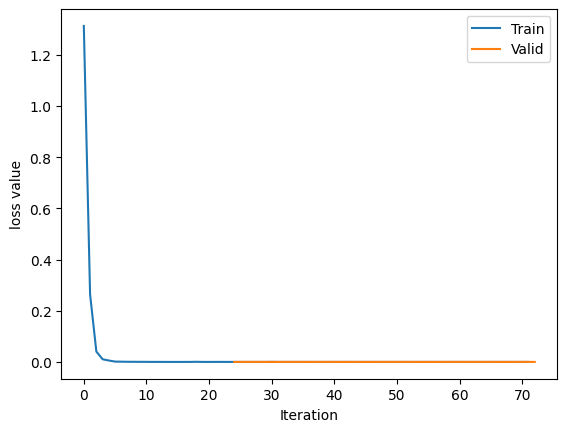

In [113]:
train_x = range(len(train_curve))
train_y = train_curve

train_iters = len(train_loader)
valid_x = np.arange(1, len(valid_curve)+1) * train_iters*val_interval # 由于valid中记录的是epochloss，需要对记录点进行转换到iterations
valid_y = valid_curve

plt.plot(train_x, train_y, label='Train')
plt.plot(valid_x, valid_y, label='Valid')

plt.legend(loc='upper right')
plt.ylabel('loss value')
plt.xlabel('Iteration')
plt.show()